In [1]:
#importing libaries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.cluster import KMeans
import sklearn 
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [2]:
print("pandas version:" ,pd.__version__)
print("numpy version:",np.__version__)
print("seaborn version:",sns.__version__)
print("scikit-learn version:",sklearn.__version__)

pandas version: 1.5.3
numpy version: 1.24.0
seaborn version: 0.12.2
scikit-learn version: 1.6.1


In [3]:
original_customers_df = pd.read_csv("dataset/Customers.csv")
original_transactions_df = pd.read_csv("dataset/Transactions.csv")

In [4]:
customers_df = original_customers_df
transactions_df = original_transactions_df

In [5]:
customers_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   CustomerID    200 non-null    object
 1   CustomerName  200 non-null    object
 2   Region        200 non-null    object
 3   SignupDate    200 non-null    object
dtypes: object(4)
memory usage: 6.4+ KB


In [6]:
transactions_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   TransactionID    1000 non-null   object 
 1   CustomerID       1000 non-null   object 
 2   ProductID        1000 non-null   object 
 3   TransactionDate  1000 non-null   object 
 4   Quantity         1000 non-null   int64  
 5   TotalValue       1000 non-null   float64
 6   Price            1000 non-null   float64
dtypes: float64(2), int64(1), object(4)
memory usage: 54.8+ KB


In [41]:
transactions_df.head(10)

,TransactionID,CustomerID,ProductID,TransactionDate,Quantity,TotalValue,Price
0,T00001,C0199,P067,2024-08-25 12:38:23,1,300.68,300.68
1,T00112,C0146,P067,2024-05-27 22:23:54,1,300.68,300.68
2,T00166,C0127,P067,2024-04-25 07:38:55,1,300.68,300.68
3,T00272,C0087,P067,2024-03-26 22:55:37,2,601.36,300.68
4,T00363,C0070,P067,2024-03-21 15:10:10,3,902.04,300.68
5,T00442,C0188,P067,2024-12-26 14:40:03,1,300.68,300.68
6,T00490,C0195,P067,2024-11-24 11:49:48,3,902.04,300.68
7,T00536,C0008,P067,2024-09-22 06:13:59,1,300.68,300.68
8,T00564,C0157,P067,2024-12-07 17:57:40,3,902.04,300.68
9,T00631,C0130,P067,2024-05-14 23:14:59,2,601.36,300.68


In [7]:
# Convert TransactionDate to datetime
transactions_df['TransactionDate'] = pd.to_datetime(transactions_df['TransactionDate'])

# Convert SignupDate to datetime
customers_df['SignupDate'] = pd.to_datetime(customers_df['SignupDate'])

In [8]:
# Calculate Recency
max_date = transactions_df['TransactionDate'].max()
recency_df = transactions_df.groupby('CustomerID')['TransactionDate'].max().reset_index()
recency_df['Recency'] = (max_date - recency_df['TransactionDate']).dt.days

# Calculate Frequency
frequency_df = transactions_df.groupby('CustomerID')['TransactionID'].count().reset_index()
frequency_df.rename(columns={'TransactionID': 'Frequency'}, inplace=True)

# Calculate Monetary
monetary_df = transactions_df.groupby('CustomerID')['TotalValue'].sum().reset_index()
monetary_df.rename(columns={'TotalValue': 'Monetary'}, inplace=True)

# Merge RFM metrics
rfm_df = recency_df.merge(frequency_df, on='CustomerID').merge(monetary_df, on='CustomerID')
rfm_df = rfm_df[['CustomerID', 'Recency', 'Frequency', 'Monetary']]

In [9]:
from sklearn.preprocessing import StandardScaler

# Normalize the data
scaler = StandardScaler()
rfm_normalized = scaler.fit_transform(rfm_df[['Recency', 'Frequency', 'Monetary']])
rfm_normalized = pd.DataFrame(rfm_normalized, columns=['Recency', 'Frequency', 'Monetary'])
rfm_normalized['CustomerID'] = rfm_df['CustomerID']

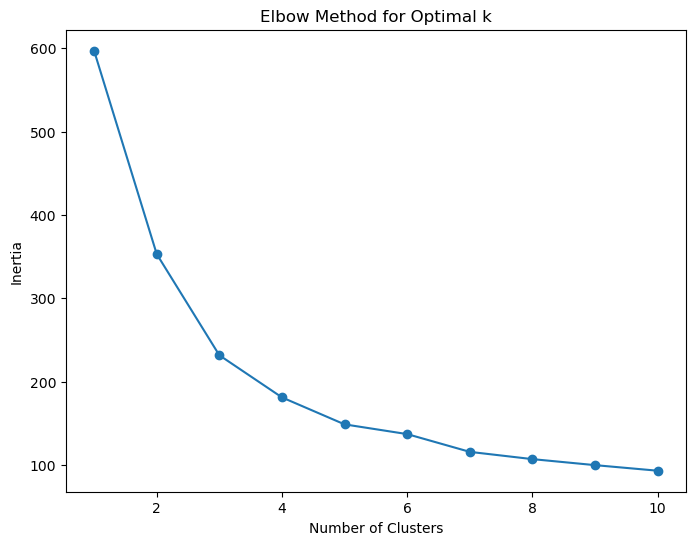

In [51]:
# Determine the optimal number of clusters using the Elbow Method
inertia = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(rfm_normalized[['Recency', 'Frequency', 'Monetary']])
    inertia.append(kmeans.inertia_)

# Plot the Elbow Curve
plt.figure(figsize=(8, 6))
plt.plot(range(1, 11), inertia, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.show()

In [22]:
# Apply K-Means with the chosen number of clusters
kmeans = KMeans(n_clusters=4, random_state=42)
rfm_normalized['Cluster'] = kmeans.fit_predict(rfm_normalized[['Recency', 'Frequency', 'Monetary']])

# Merge the cluster information back to the original RFM DataFrame
rfm_df['Cluster'] = rfm_normalized['Cluster']

In [23]:
# Calculate the average RFM values for each cluster
cluster_summary = rfm_df.groupby('Cluster').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': 'mean'
}).reset_index()

print(cluster_summary)

   Cluster     Recency  Frequency     Monetary
0        0   34.736842   8.236842  5958.357895
1        1   50.675325   3.714286  2176.816883
2        2  243.823529   1.764706  1070.562353
3        3   79.656716   5.537313  4145.723881


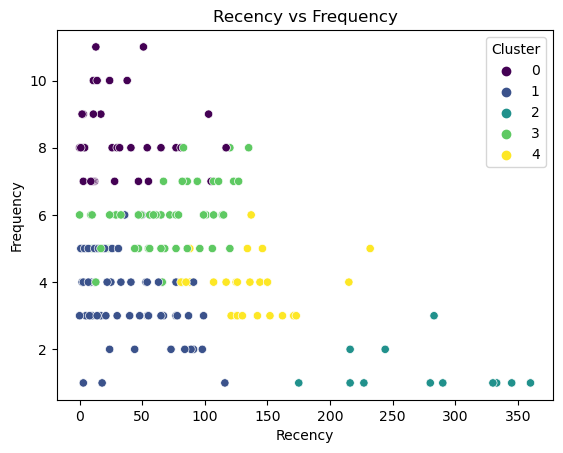

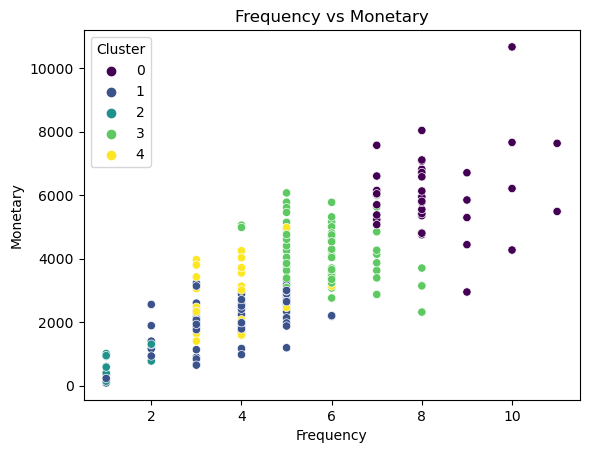

In [17]:
# Scatter plot of Recency vs Frequency
sns.scatterplot(data=rfm_df, x='Recency', y='Frequency', hue='Cluster', palette='viridis')
plt.title('Recency vs Frequency')
plt.show()

# Scatter plot of Frequency vs Monetary
sns.scatterplot(data=rfm_df, x='Frequency', y='Monetary', hue='Cluster', palette='viridis')
plt.title('Frequency vs Monetary')
plt.show()

In [24]:
from sklearn.metrics import davies_bouldin_score

# Ensure rfm_normalized contains only numeric features
rfm_numeric = rfm_normalized.drop(columns=['CustomerID'])  # Drop non-numeric columns

# Calculate DB Index
db_index = davies_bouldin_score(rfm_numeric, rfm_df['Cluster'])
print(f'Davies-Bouldin Index: {db_index}')

Davies-Bouldin Index: 0.6356322183787142


In [34]:
from sklearn.metrics import silhouette_score

silhouette = silhouette_score(rfm_normalized[['Recency', 'Frequency', 'Monetary']], rfm_df['Cluster'])
print(f'Silhouette Score: {silhouette}')

Silhouette Score: 0.319042374755892


# Cluster Profiling Interpretation  

The clustering is based on **Recency, Frequency, and Monetary (RFM) analysis**, commonly used in customer segmentation.

| Cluster | Recency (R) | Frequency (F) | Monetary (M) |
|---------|------------|--------------|-------------|
| **0** (Best Customers) | 34.73 | 8.24 | 5958.36 |
| **1** (Average Customers) | 50.67 | 3.71 | 2176.82 |
| **2** (Churned Customers) | 243.82 | 1.76 | 1070.56 |
| **3** (Loyal Customers) | 79.66 | 5.54 | 4145.72 |

---

## Cluster-wise Customer Profiling  

### Cluster 0: Best Customers (High-Value Customers)
- **Recency**: 34.73 (Low) → Recently engaged customers.
- **Frequency**: 8.24 (High) → Purchase very frequently.
- **Monetary**: 5958.36 (Very High) → Highest spending customers.
- **Interpretation**:  
  - These are the best and most engaged customers.
  - They buy frequently and have high spending power.
- **Retention Strategy**:  
  - Provide VIP treatment, loyalty rewards, and exclusive deals.

---

### Cluster 1: Average Customers
- **Recency**: 50.67 (Moderate) → Purchased relatively recently.
- **Frequency**: 3.71 (Medium) → Purchase occasionally.
- **Monetary**: 2176.82 (Medium) → Moderate spending.
- **Interpretation**:  
  - These are casual buyers but still contribute to revenue.
  - Might convert into loyal customers with the right incentives.
- **Retention Strategy**:  
  - Send personalized promotions and product recommendations.
  - Offer discounts on their next purchase.

---

### Cluster 2: Churned Customers (Lost Customers)
- **Recency**: 243.82 (Very High) → Haven’t purchased in a long time.
- **Frequency**: 1.76 (Very Low) → Rarely purchase.
- **Monetary**: 1070.56 (Low) → Low spending.
- **Interpretation**:  
  - These are lost customers who haven’t engaged in a long time.
  - They have low purchase frequency and spending.
- **Retention Strategy**:  
  - Win-back campaigns like special discounts for re-engagement.
  - Email reminders with new product launches or seasonal discounts.
  - Ask for customer feedback to understand why they left.

---

### Cluster 3: Loyal Customers
- **Recency**: 79.66 (Moderate) → Fairly recent buyers.
- **Frequency**: 5.54 (High) → Buy regularly.
- **Monetary**: 4145.72 (High) → Spend a lot.
- **Interpretation**:  
  - These customers love the brand and buy frequently.
  - They are not as engaged as Cluster 0 (Best Customers) but still valuable.
- **Retention Strategy**:  
  - Convert them into brand advocates through referral programs.
  - Provide loyalty rewards and priority support.
  - Offer early access to sales or bundled offers.

---

## Final Recommendations
1. **Focus on Clusters 0 & 3** → These are high-value and repeat customers. Keep them engaged with VIP programs, rewards, and special deals.
2. **Convert Cluster 1 into Cluster 3** → They have potential; provide personalized offers and engagement.
3. **Re-engage Cluster 2 (Lost Customers)** → Run win-back campaigns and understand why they left.
4. **Monitor Cluster Movement** → Track how customers move between these clusters over time.
